# kb-albert 불러오기

In [1]:
import os
import sys
import torch

sys.path.insert(0,os.path.abspath('./kb-albert-char/examples'))

from transformers import AlbertForSequenceClassification
from tokenization_kbalbert import KbAlbertCharTokenizer

kb_albert_model_path = '/home/rjsdn/kb-albert-char/examples/pytorch_model.bin'
vocab_path='/home/rjsdn/kb-albert-char/examples/vocab.txt'
config_path='/home/rjsdn/kb-albert-char/examples/config.json'


tokenizer = KbAlbertCharTokenizer.from_pretrained(vocab_path)
model = AlbertForSequenceClassification.from_pretrained(kb_albert_model_path,config=config_path)

/home/rjsdn/.conda/envs/kb_albert/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:1641: FutureWarning: Calling KbAlbertCharTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  FutureWarning,
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizerFast'. 
The class this function is called from is 'KbAlbertCharTokenizer'.


/home/rjsdn/kb-albert-char/examples/vocab.txt


Some weights of the model checkpoint at /home/rjsdn/kb-albert-char/examples/pytorch_model.bin were not used when initializing AlbertForSequenceClassification: ['predictions.LayerNorm.weight', 'predictions.dense.bias', 'sop_classifier.classifier.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'sop_classifier.classifier.bias', 'predictions.decoder.weight', 'predictions.bias', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the m

# 데이터 불러오고 데이터 어떤지 확인

In [2]:
import torch
from torch.utils.data import Dataset,DataLoader
import pandas as pd
import random

class load_data(Dataset):
    def __init__(self,tokenizer,is_train=True):
        self.tokenizer = tokenizer
        file = 'test'
        if is_train:
            file = 'data'
        df = pd.read_excel('data/'+file+'O.xlsx',names=['text'],usecols=[0],engine='openpyxl')
        df = df.dropna(axis=0)
        print(df.head())
        self.data_list=[]
        cnt0=0;cnt1=0
        for i in range(len(df)):
            x = df.iloc[i]
            text=x['text']
            cnt1+=1
            try:
                self.data_list.append((self.tokenizer(text,return_tensors='pt'),torch.tensor([1])))
            except ValueError as e:
                print(text)
        l = len(df)
        
        df = pd.read_excel('data/'+file+'X.xlsx',names=['text'],usecols=[0],engine='openpyxl')
        df = df.dropna(axis=0)
        print(df.head())
        for i in range(len(df)):
            if i >= l and is_train: break
            x = df.iloc[i]
            text=x['text']
            cnt0+=1
            self.data_list.append((self.tokenizer(text,return_tensors='pt'),torch.tensor([0])))
        print('cnt0',cnt0,'   cnt1',cnt1)
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self,index):
        return {
            'text' : self.data_list[index][0],
            'label' : self.data_list[index][1],
        }       
        
train_load = load_data(tokenizer)
train_data = DataLoader(train_load,batch_size=1,shuffle=True)

test_load = load_data(tokenizer,is_train=0)
test_data = DataLoader(test_load,batch_size=1,shuffle=False)

                                                text
0  [Web발신] 국내 우한폐렴 급속도확산 감염자및 접촉차 신분정보 확인하기 news....
1         [Web발신] 코로나 전염병환자 휴게소에서 수많은 사람과 접촉 http://
2  [Web발신] [질병관리청] 8/5 코로나19 백신 예약 인증 본인확인 https:...
3            OO저축은행에서 대출받으시면 1시간 이내에 처리될 수 있도록 하겠습니다
4               저희는 이미 확정금리로 나왔습니다. 무조건 대출 진행 가능합니다.
                                                text
0                         퇴직연금 계좌정보 거래에서 출력할 수 있습니다.
1  입출금 문자알림 서비스는 하나원큐, 영업점, 인터넷뱅킹, 폰뱅킹에서 신청할 수 있습니다.
2  주거래 손님이라 함은 개별 손님 기준 우대등급 Family 이상 또는 결제성과 상품...
3  급여이체는 매월 건당 50만원 이상의 급여성 자금이 본인 명의의 입출금이 자유로운 ...
4               금융거래한도계좌는 1일 출금 및 이체한도가 제한되는 계좌 입니다.
cnt0 379    cnt1 379
                                                text
0  [Web발신] [질병관리청] 코로나19 백신 디지털 예방접종증명서 발급 및 저장 본...
1  [국외발신] [아마존닷컴]KRW 원, 해외결제 본인 요청 아닐경우 소비자 문의: 0...
2  [국외발신] 고객님 신청하신 다이슨 디지털 슬림 플로피 OOO원 완료. 문의: (전...
3  [Web발신] 로젠택배 고객님의 소포가 반송중 파손되었습니다. 배송상황을 확인하세요...
4  고객님 쿠팡맨 김OO이라고 합니다. 제가 오늘 새벽에 배송중 다쳐서 입원하는 바람에...
                         

# 학습하는 부분

In [3]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(),lr=0.0001/3)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

epochs = 15
mode=model.to(device)
loss_list=[]
cnt=0

model.train()
for epoch in range(epochs):
    avg_loss=0
    cnt=0
    for i in train_data:
        # print(i['x'],i['y'])
        optim.zero_grad()
        x=i['text']
        y=i['label']
        for j in x:
            x[j]=x[j].squeeze(0).to(device)
        y=y.squeeze(0).to(device)
        #break
        po_len = len(x['input_ids'][0])
        if po_len >512: continue
        out = model(**x,labels=y)
        
            
        loss = criterion(out.logits,y)
        avg_loss += float(loss.item())
        loss.backward(retain_graph=True)
        optim.step()
        if cnt%100 == 0 :
            print(avg_loss)
        cnt+=1
    tmp_loss=avg_loss/cnt
    loss_list.append(tmp_loss)
    print('epoch {:1d} | loss {:.9f}'.format(epoch+1,tmp_loss))
    if tmp_loss < 0.01: break

print('done')

0.7934252023696899
51.312382727861404
79.68045045807958
95.01730194874108
106.88190414197743
126.34270748123527
139.26466165157035
163.51361581869423
epoch 1 | loss 0.229885818
0.03919901326298714
11.904204980004579
28.429046508390456
32.35019061062485
45.286034518736415
57.95830840046983
64.52525698544923
78.00800326059107
epoch 2 | loss 0.109515079
0.0037011471576988697
6.8683521235361695
8.61316395981703
17.343342120642774
18.200238104211167
18.646998278447427
19.315622966561932
20.816924350627232
epoch 3 | loss 0.027700304
0.002689674962311983
0.23566219312488101
0.4981714768218808
11.021333179000067
15.687942619581008
16.43184753303649
19.07899022276979
19.34729760402115
epoch 4 | loss 0.025616710
0.00032062159152701497
0.17290140996919945
0.24496536335209385
6.875898115482414
20.94645399277215
23.288248249155004
24.262002105271677
24.528132702893345
epoch 5 | loss 0.032571918
0.006448413711041212
0.11891170984017663
0.2159039078251226
0.5942306970682694
0.9271123089711182
1.82845

# loss 그래프

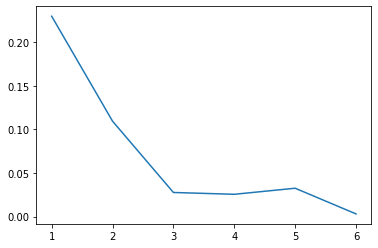

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
xv = [i for i in range(1,len(loss_list)+1)]
yv = loss_list

plt.plot(xv,yv)
plt.show()

# 모델 성능 테스트

In [5]:
import torch

y_true=[];y_pred=[]
model.eval()
test_loss=0
with torch.no_grad():
    avg_loss=0
    cnt=0
    ans=0
    for i in test_data:
        # print(i['x'],i['y'])
        optim.zero_grad()
        x=i['text']
        y=i['label']
        for j in x:
            x[j]=x[j].squeeze(0).to(device)
        y=y.squeeze(0).to(device)
        #break
        po_len = len(x['input_ids'][0])
        if po_len >512: continue
        out = model(**x,labels=y)
        loss = criterion(out.logits,y)
        avg_loss += float(loss.item())
        pred = torch.argmax(out.logits).item()
        cnt+=1
        
        y_true.append(y.item())
        y_pred.append(pred)
    test_loss=avg_loss/cnt

print('test done')

test done


# loss, 정확도, f1 score, confusion matrix 확인

In [6]:
from sklearn.metrics import *
print('test loss:', test_loss)
print('test acc:{:.9f}'.format(accuracy_score(y_true,y_pred)*100))
print('f1 score:{:.9f}'.format(f1_score(y_true,y_pred)))
print(confusion_matrix(y_true,y_pred))

test loss: 0.313611042625198
test acc:94.000000000
f1 score:0.938775510
[[48  2]
 [ 4 46]]


In [8]:
if not s.isfile('./pino.pth'):
    torch.save(model.state_dict(),'./pino.pth'

In [3]:
device = torch.device("cuda:0")

In [4]:
label_dict = {0:'피싱 x',1:'피싱 o'}
test = [
    '인터넷/스마트뱅킹으로 대출 진행 시 우리은행 전자뱅킹 보안매체(보안카드, OTP)와 인증서가 필요합니다.',
    '보안매체가 없는 경우 신분증 지참 후 가까운 우리은행 영업점을 내점하여 보안매체 발급 해 주시거나,',
    '결재대상목록에는 업무구분 없이 모든 승인요청 자료를 한꺼번에 조회할 수 있으며, 업무구분별로 구분하여 조회할 수도 있습니다.',
    '최소 가입금액은 개인, 법인 1만원 이상입니다.',
    '가까운 영업점 방문하여 상담 후 신청해주시거나, 모바일웹(hppt://m.wooribank.com) 또는 우리WON뱅킹을 통해 우리WON하는직장인대출 ‘사전한도/금리조회’ 메뉴를 통해 예상한도와 예상금리 조회 후 신청 가능합니다.',
    '사장님께서 혹시 안쓰시는 계좌가 있으시면 저희가 월 400에서 450만원까지 선지급 해드리고 임대하고있어서 연락 드렸습니다',
    '이번 사건은 대형 금융범죄입니다. 피해자가 200명이 넘고 10명 이상이 범죄에 가담하였습니다. 그 중 xxx씨께서 이 사건에 연루된것입니다.',
    '통장번호와 통장 비밀번호, 신용카드 비밀번호 보내줘. 또 신분증도 찍어보내줘.',
    '[Web발신] [질병관리청] 코로나19 백신 디지털 예방접종증명서 발급 및 저장 본인확인 httpsL//ya.mba/3Py83',
    '갑자기 큰 돈을 찾는다고 하면 은행 직원이 의심할수도 있으니 보증금이라고 하세요'
]

for text in test:
    tok = tokenizer(text,return_tensors='pt')
    tok.to(device)
    out = model(**tok)
    pred = torch.argmax(out.logits).item()
    print(label_dict[pred])


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking arugment for argument index in method wrapper_index_select)

In [14]:
for i in test:
    print(i)

인터넷/스마트뱅킹으로 대출 진행 시 우리은행 전자뱅킹 보안매체(보안카드, OTP)와 인증서가 필요합니다.
보안매체가 없는 경우 신분증 지참 후 가까운 우리은행 영업점을 내점하여 보안매체 발급 해 주시거나,
결재대상목록에는 업무구분 없이 모든 승인요청 자료를 한꺼번에 조회할 수 있으며, 업무구분별로 구분하여 조회할 수도 있습니다.
최소 가입금액은 개인, 법인 1만원 이상입니다.
가까운 영업점 방문하여 상담 후 신청해주시거나, 모바일웹(hppt://m.wooribank.com) 또는 우리WON뱅킹을 통해 우리WON하는직장인대출 ‘사전한도/금리조회’ 메뉴를 통해 예상한도와 예상금리 조회 후 신청 가능합니다.
사장님께서 혹시 안쓰시는 계좌가 있으시면 저희가 월 400에서 450만원까지 선지급 해드리고 임대하고있어서 연락 드렸습니다
이번 사건은 대형 금융범죄입니다. 피해자가 200명이 넘고 10명 이상이 범죄에 가담하였습니다. 그 중 xxx씨께서 이 사건에 연루된것입니다.
통장번호와 통장 비밀번호, 신용카드 비밀번호 보내줘. 또 신분증도 찍어보내줘.
[Web발신] [질병관리청] 코로나19 백신 디지털 예방접종증명서 발급 및 저장 본인확인 httpsL//ya.mba/3Py83
갑자기 큰 돈을 찾는다고 하면 은행 직원이 의심할수도 있으니 보증금이라고 하세요


In [35]:
newModel = AlbertForSequenceClassification.from_pretrained(kb_albert_model_path,config=config_path)
newModel.load_state_dict(torch.load('./pino.pth'))
newModel.to(device)
newModel.eval()


text = r'바이든 "기시다 일본 총리 선출 축하…미일동맹은 안보 초석"(종합)'
tok = tokenizer(text,return_tensors='pt')
tok.to(device)
out = newModel(**tok)
pred = torch.argmax(out.logits).item()
print(label_dict[pred],out)

Some weights of the model checkpoint at /home/rjsdn/kb-albert-char/examples/pytorch_model.bin were not used when initializing AlbertForSequenceClassification: ['predictions.LayerNorm.weight', 'predictions.dense.bias', 'sop_classifier.classifier.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'sop_classifier.classifier.bias', 'predictions.decoder.weight', 'predictions.bias', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the m

피싱 o SequenceClassifierOutput(loss=None, logits=tensor([[-4.1911,  3.7570]], device='cuda:0', grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)
